In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os
import models.unet_precip_regression_lightning as unet_regr
from utils import dataset_precip

dataset = dataset_precip.precipitation_maps_oversampled_h5(
            in_file="dataset/train_test_input-length_12_image-ahead_6_rain-threshold_0.h5",
            num_input_images=12,
            num_output_images=6, train=False)
# 222, 444, 777, 1337 is fine
x, y_true = dataset[222]
# add batch dimension
x = torch.tensor(x).unsqueeze(0)
y_true = torch.tensor(y_true).unsqueeze(0)
print(x.shape, y_true.shape)

models_dir = "checkpoints/comparison"
precip_models = [m for m in os.listdir(models_dir) if ".ckpt" in m]
print(precip_models)

loss_func = nn.MSELoss(reduction="sum")
print("Persistence", loss_func(x.squeeze()[-1]*260.0, y_true.squeeze()*260.0).item())

plot_images = dict()
for i, model_file in enumerate(precip_models):
    # model_name = "".join(model_file.split("_")[0])
    if "UNet_Attention" in model_file:
        model_name = "UNet with CBAM"
        model = unet_regr.UNet_Attention
    elif "UNetDS_Attention_4CBAMs" in model_file:
        model_name = "UNetDS Attention 4CBAMs"
        model = unet_regr.UNetDS_Attention_4CBAMs
    elif "UNetDS_Attention" in model_file:
        model_name = "SmaAt-UNet"
        model = unet_regr.UNetDS_Attention
    elif "UNetDS" in model_file:
        model_name = "UNet with DSC"
        model = unet_regr.UNetDS
    elif "UNet" in model_file:
        model_name = "UNet"
        model = unet_regr.UNet
    else:
        raise NotImplementedError(f"Model not found")
    model = model.load_from_checkpoint(f"{models_dir}/{model_file}")
    # loaded = torch.load(f"{models_dir}/{model_file}")
    # model = loaded["model"]
    # model.load_state_dict(loaded["state_dict"])
    # loss_func = nn.CrossEntropyLoss(weight=torch.tensor([1., 2., 3., 4., 5., 6., 7., 8.]))

    model.to("cpu")
    model.eval()

    # get prediction of model
    with torch.no_grad():
        y_pred = model(x)
    y_pred = y_pred.squeeze()
    print(model_name, loss_func(y_pred*260.0, y_true.squeeze()*260.0).item())

    plot_images[model_name] = y_pred

torch.Size([1, 12, 80, 240]) torch.Size([1, 80, 240])
['UNetDS_Attention_rain_threshold_50_epoch=9-val_loss=0.272466.ckpt', 'UNetDS_rain_threshold_50_epoch=11-val_loss=0.388306.ckpt', 'UNet_Attention_rain_threshold_50_epoch=13-val_loss=0.250151.ckpt', 'UNet_rain_threshold_50_epoch=17-val_loss=0.499727.ckpt']
Persistence 221.77386474609375
SmaAt-UNet 406.607421875
UNet with DSC 1782.6507568359375
UNet with CBAM 588.4886474609375
UNet 612.9428100585938


SmaAt-UNet
UNet with DSC
UNet with CBAM
UNet


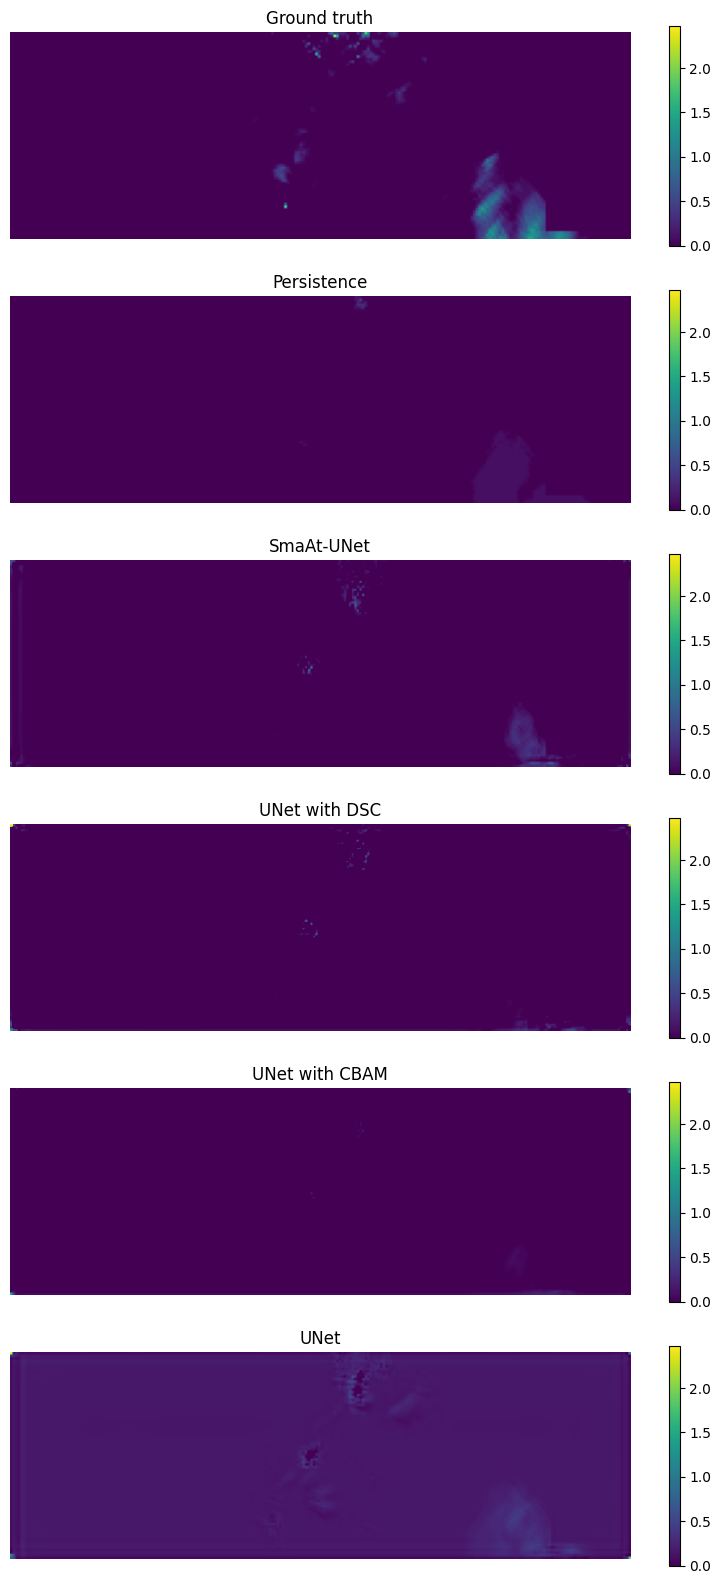

In [2]:
#### Plotting ####
plt.figure(figsize=(10, 20))
plt.subplot(len(precip_models)+2, 1, 1)
plt.imshow(y_true.squeeze()*260.0)
plt.colorbar()
plt.title("Ground truth")
plt.axis("off")

plt.subplot(len(precip_models)+2, 1, 2)
plt.imshow(x.squeeze()[-1]*260.0, vmax=torch.max(y_true*260.0), vmin=torch.min(y_true*260.0))
plt.colorbar()
plt.title("Persistence")
plt.axis("off")

for i, (model_name, y_pred) in enumerate(plot_images.items()):
    print(model_name)
    plt.subplot(len(precip_models)+2, 1, i+3)
    plt.imshow(y_pred*260.0, vmax=torch.max(y_true*260.0), vmin=torch.min(y_true*260.0))
    plt.colorbar()
    plt.title(model_name)
    plt.axis("off")
# plt.colorbar()
plt.show()

SmaAt-UNet
UNet with DSC
UNet with CBAM
UNet


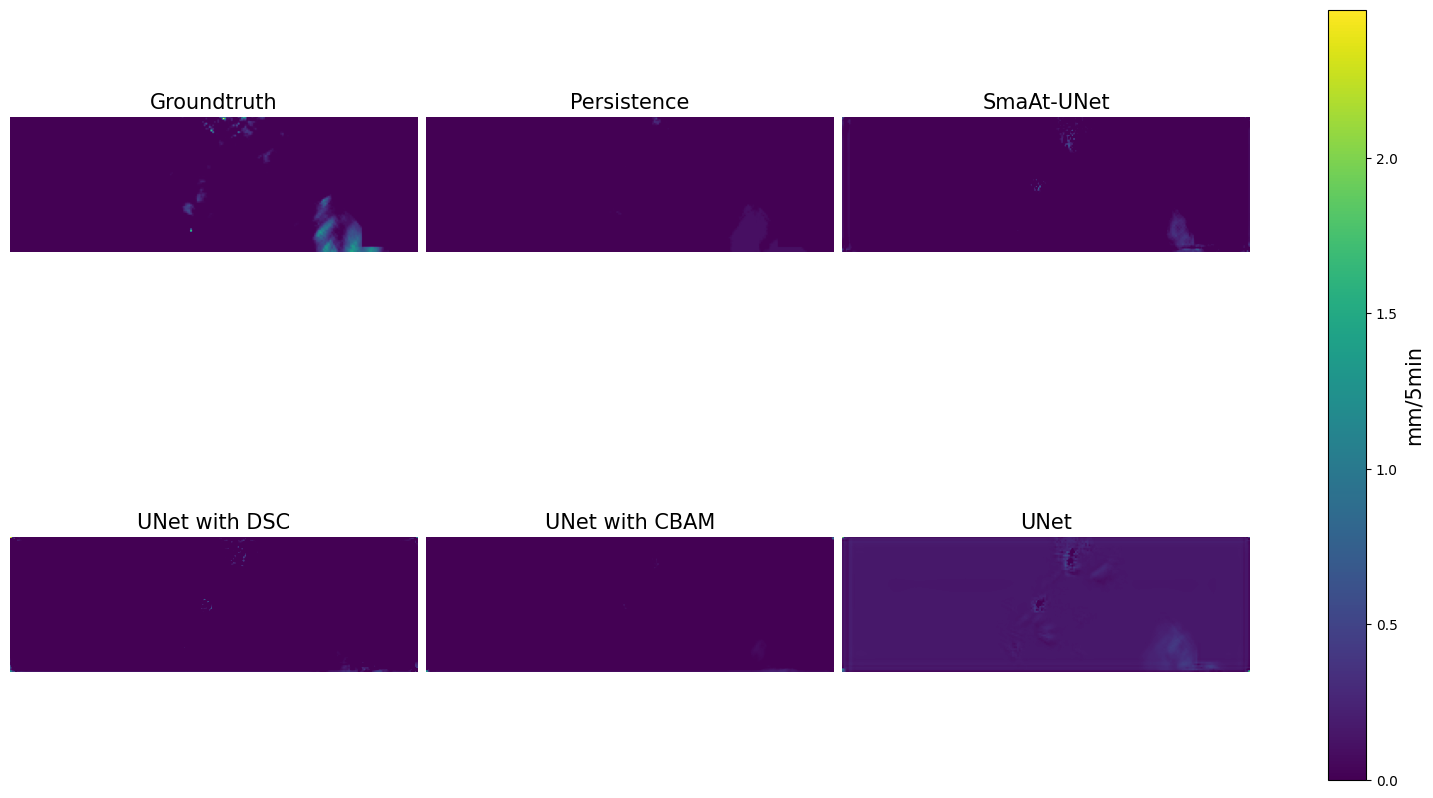

In [3]:
fig, axesgrid = plt.subplots(nrows=2, ncols=(len(precip_models)+2)//2, figsize=(20, 10))
axes = axesgrid.flat
im = axes[0].imshow(y_true.squeeze()*260.0)
axes[0].set_title("Groundtruth", fontsize=15)
axes[0].set_axis_off()
axes[1].imshow(x.squeeze()[-1]*260.0, vmax=torch.max(y_true*260.0), vmin=torch.min(y_true*260.0))
axes[1].set_title("Persistence", fontsize=15)
axes[1].set_axis_off()

# for ax in axes.flat[2:]:
for i, (model_name, y_pred) in enumerate(plot_images.items()):
    print(model_name)
#     plt.subplot(len(precip_models)+2, 1, i+3)
    axes[i+2].imshow(y_pred*260.0, vmax=torch.max(y_true*260.0), vmin=torch.min(y_true*260.0))
    axes[i+2].set_title(model_name, fontsize=15)
    axes[i+2].set_axis_off()
#     im = ax.imshow(np.random.random((16, 16)), cmap='viridis',
#                    vmin=0, vmax=1)

fig.subplots_adjust(wspace=0.02)
cbar = fig.colorbar(im, ax=axesgrid.ravel().tolist(), shrink=1)
cbar.ax.set_ylabel('mm/5min', fontsize=15)
plt.savefig("plots/Precip_example.eps")
plt.savefig("plots/Precip_example.png", dpi=300)
plt.show()